In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
car1 = glob.glob('vehicles/GTI_Far/*.png')
car2 = glob.glob('vehicles/GTI_Left/*png')
car3 = glob.glob('vehicles/GTI_MiddleClose/*.png')
car4 = glob.glob('vehicles/GTI_Right/*.png')
car5 = glob.glob('vehicles/KITTI_extracted/*.png')
cars = np.concatenate((car1,car2,car3,car4,car5))

non_car1 = glob.glob('non-vehicles/Extras/*.png')
non_car2 = glob.glob('non-vehicles/GTI/*.png')
non_cars = np.concatenate((non_car1,non_car2))

In [3]:
#Define a function to return HOG features and visualization
#Reference Udacity's Self Driving Car Nanodegree lectures
def bin_spatial(img, size=(32,32)):
    return cv2.resize(img,size).ravel()

def convert_color(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
    return feature_image
        
def color_hist(img, nbins=32, bins_range=(0,256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def get_hog_feature(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img,orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  visualise=vis, transform_sqrt=True, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img,orientations=orient,pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                        feature_vector=feature_vec)
        return features

#Extract Iimage features
def extract_features(imgs,cspace='RGB', spatial=True, spatial_size=(32,32),
                     hist_feature=True, nbins=32, orient=9,pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for img in imgs:
        image = mpimg.imread(img)
        img_features = []
        
        #Convert Color
        feature_image = convert_color(image, cspace=cspace)
            
        #Spatial Feature
        if spatial == True:
            img_features.append(bin_spatial(feature_image, spatial_size))
            
        #Histogram Color features
        if hist_feature == True:
            hist_features = color_hist(feature_image, nbins)
            img_features.append(hist_features)
            
        #HOG Features
        if hog_channel == 'ALL':
            hog_feature = []
            for channel in range(feature_image.shape[2]):
                hog_feature.append(get_hog_feature(feature_image[:, :, channel], orient, pix_per_cell,
                                                   cell_per_block, vis=False, feature_vec=True))
            hog_feature = np.ravel(hog_feature)
        else:
            hog_feature = get_hog_feature(feature_image[:, :, hog_channel], orient, pix_per_cell,
                                          cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_feature)
        features.append(np.concatenate(img_features))
        
    return features

In [ ]:
# cars = cars[0:sample_size]
# non_cars = non_cars[0:sample_size]
colorspace = 'YCrCb'
spatial_size = (32,32)
nbins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

t=time.time()
car_features = extract_features(cars, cspace=colorspace, spatial_size=spatial_size,
                                nbins=nbins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel)

noncar_features = extract_features(non_cars, cspace=colorspace, spatial_size=spatial_size,
                                nbins=nbins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel)
#Training Input
X = np.vstack((car_features, noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.concatenate((np.ones(len(cars)), np.zeros(len(non_cars))))

### Extract Hog Example

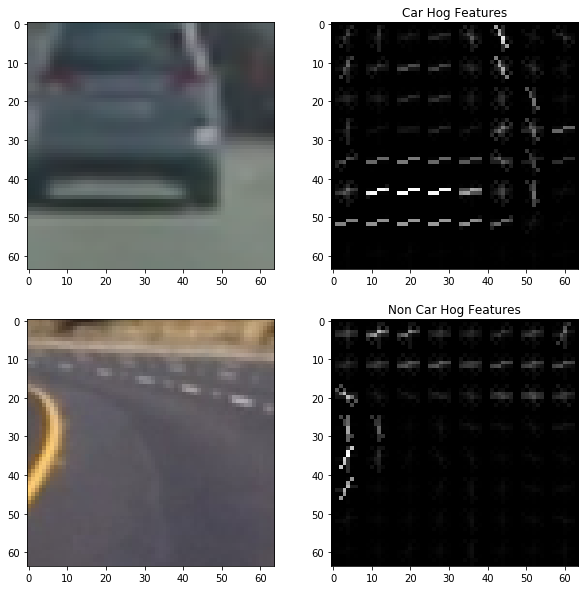

In [10]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
car = mpimg.imread(cars[np.random.randint(1,10)])
car_features, car_hog = get_hog_feature(car[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

noncar = mpimg.imread(non_cars[np.random.randint(1,10)])
noncar_features, noncar_hog = get_hog_feature(noncar[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(car)
plt.subplot(222)
plt.subplot(222).set_title('Car Hog Features')
plt.imshow(car_hog, cmap='gray')
plt.subplot(223)
plt.imshow(noncar)
plt.subplot(224)
plt.subplot(224).set_title('Non Car Hog Features')
plt.imshow(noncar_hog, cmap='gray')


In [ ]:
#http://datascience.stackexchange.com/questions/12321/difference-between-fit-and-fit-transform-in-scikit-learn-models
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.20, random_state = 42)
svc = LinearSVC()
svc.fit(X_train, y_train)
# n_predict = 20
accuracy = svc.score(X_test,y_test)
# predict = svc.predict(X_test[0:500])
print ('Accuracy: ',accuracy)
# print ('Prediction: ',predict)
# print ('Actual: ', y_test[0:500])

In [ ]:
car1 = mpimg.imread('test6.jpg')
car = get_hog_feature(car1[:,:,0], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
print (car.shape)
print (np.concatenate(([1,3,4],[4,5,6],[3,2])).reshape(1,-1))

In [ ]:
import pickle
import os
pickle_file = 'SVMvehicles.p'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('SVMvehicles.p', 'wb') as pfile:
            pickle.dump(
            {
                'svm_model': svc,
                'scaler' : X_scaler,
                'color_space': colorspace,
                'spatial_size': spatial_size,
                'bins_number': nbins,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel': hog_channel
            },
            pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
        
print('Data cached in pickle file.')

### Checkpoint

In [ ]:
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from scipy.ndimage.measurements import label
from collections import deque
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

pickle_file = 'SVMvehicles.p'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    svc = pickle_data['svm_model']
    X_scaler = pickle_data['scaler']
    colorspace = pickle_data['color_space']
    spatial_size = pickle_data['spatial_size']
    nbins = pickle_data['bins_number']
    orient = pickle_data['orient']
    pix_per_cell = pickle_data['pix_per_cell']
    cell_per_block = pickle_data['cell_per_block']
    hog_channel = pickle_data['hog_channel']
    del pickle_data
    
print('Data and modules loaded')

In [ ]:
def find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                spatial_size, hist_bins):
    
    draw_image = np.copy(image)
    scaled_image = image.astype(np.float32)/255
    
    #Region of Interest (ROI)
    image_roi = scaled_image[ystart:ystop,:,:]
    search_image = convert_color(image_roi,cspace='YCrCb')
    
    #Scale ROI
    imshape = search_image.shape
    if scale != 1:
        search_image = cv2.resize(search_image, (np.int(imshape[1]/scale), (np.int(imshape[0]/scale))))

    #Blocks of the entire region of interest
    nx_blocks = (search_image.shape[1]//pix_per_cell) - cell_per_block + 1
    ny_blocks = (search_image.shape[0]//pix_per_cell) - cell_per_block + 1
    
    #Window without steps
    window = 64
    window_blocks = (window//pix_per_cell) - cell_per_block + 1
    cell_per_window = window//pix_per_cell
    x_windows = search_image.shape[1]//window
    y_windows = search_image.shape[0]//window
    
    #With steps
    cell_per_step = 2
    step_per_window = cell_per_window//cell_per_step
    nxsteps = (x_windows-1)*step_per_window
    nysteps = (y_windows-1)*step_per_window
    
    #Extract hog features without feature vector in all channel
    hog1 = get_hog_feature(search_image[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_feature(search_image[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_feature(search_image[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_boxes = []
    for xstep in range(nxsteps):
        for ystep in range(nysteps):
            #Cell position
            ypos = ystep*cell_per_step
            xpos = xstep*cell_per_step
            #Extract HOG for each step
            hog_feat1 = hog1[ypos:ypos+window_blocks, xpos:xpos+window_blocks].ravel()
            hog_feat2 = hog2[ypos:ypos+window_blocks, xpos:xpos+window_blocks].ravel()
            hog_feat3 = hog3[ypos:ypos+window_blocks, xpos:xpos+window_blocks].ravel()
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
            
            #Pixel position
            x_left = xpos*pix_per_cell
            y_top = ypos*pix_per_cell
            
            #Window Image
            sub_img = cv2.resize(search_image[y_top:y_top+window, x_left:x_left+window],(64,64))
            
            #Spatial and Color Features
            spatial_features = bin_spatial(sub_img, spatial_size)
            color_hist_features = color_hist(sub_img, nbins=hist_bins, bins_range=(0,256))
            
            #Combine test features
            test_features = X_scaler.transform(np.concatenate((spatial_features,color_hist_features,hog_features)).reshape(1,-1))
            
            prediction = svc.predict(test_features)
            if prediction == 1:
                xleft_draw = np.int(x_left*scale)
                ytop_draw = np.int(y_top*scale) + ystart
                win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_image,(xleft_draw,ytop_draw), (xleft_draw+win_draw, ytop_draw+win_draw),(0,0,255),6)
                car_boxes.append(((xleft_draw,ytop_draw),(xleft_draw+win_draw, ytop_draw+win_draw)))
    
    return car_boxes

#Add head
def add_heat(heatmap, car_boxes):
    for box in car_boxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

#Heatmap threshold
def heat_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

#Draw car
def draw_car_box(image, labels):
    for car_number in range(1,labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        car_y = np.array(nonzero[0])
        car_x = np.array(nonzero[1])
        top_left = (np.min(car_x),np.min(car_y))
        bottom_right = (np.max(car_x),np.max(car_y))
        cv2.rectangle(image, top_left, bottom_right, (0,0,255), 6)
        
    return image



In [ ]:
ystart = 400
ystop = 650
# scale = 0.5
images = glob.glob('test_images/*.jpg')
scales = [0.75, 1, 1.25, 1.5]
n = 1
for image in images:
    car_boxes = []
    img = mpimg.imread(image)
    for scale in scales:
        car_boxes.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
                           pix_per_cell, cell_per_block, spatial_size, hist_bins = nbins))
    for box in car_boxes:
        img = cv2.rectangle(img, box[0], box[1], (0,0,255), 6)
    mpimg.imsave('output_images/test'+str(n)+'.jpg', img)
    n += 1
print('Done saving test images.')

In [ ]:
ystart = 400
ystop = 650
# scale = 0.5
image = mpimg.imread('test_images/test1.jpg')
scales = [0.75,1,1.5,1.75]
car_boxes = []
for scale in scales:
    car_boxes.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, 
                                      pix_per_cell, cell_per_block, spatial_size, hist_bins = nbins))

    
heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat, car_boxes)
heatmap = np.clip(heat,0,255)
labels = label(heat)
draw_img = draw_car_box(np.copy(image),labels)

heat1 = heat_threshold(heat,2)
heatmap1 = np.clip(heat1,0,255)
labels1 = label(heat1)
draw_img1 = draw_car_box(np.copy(image),labels1)

heat2 = heat_threshold(heat,3)
heatmap2 = np.clip(heat2,0,255)
labels2 = label(heat2)
draw_img2 = draw_car_box(np.copy(image),labels2)

fig = plt.figure(figsize=(20,15))
plt.subplot(321)
plt.imshow(draw_img)
plt.subplot(322)
plt.subplot(322).set_title('No Threshold')
plt.imshow(heatmap, cmap='hot')
plt.subplot(323)
plt.imshow(draw_img1)
plt.subplot(324)
plt.subplot(324).set_title('Threshold = 2')
plt.imshow(heatmap1, cmap='hot')
plt.subplot(325)
plt.imshow(draw_img2)
plt.subplot(326)
plt.subplot(326).set_title('Threshold = 3')
plt.imshow(heatmap2, cmap='hot')
# fig.tight_layout()

In [ ]:
print (heatmap.shape)
print (heatmap.max())
# histogram = np.sum(heat,axis=0)
a = heatmap.ravel()[heatmap.ravel()>0]
# histogram = np.histogram(a, bins = 10)
plt.hist(a, bins=10)
plt.show()

In [ ]:
n = 15
car_topLeft = [deque(maxlen=n) for x in range(n)]
car_lowRight = [deque(maxlen=n)for x in range(n)]
def process(image):
    ystart = 400
    ystop = 650
#     scale = 1.5
#     scale1 = 0.75
#     car_boxes1 = find_cars(image, ystart, ystop, scale1, svc, X_scaler, orient, 
#                                       pix_per_cell, cell_per_block, spatial_size, hist_bins = nbins)
#     scale2 = 1.5
#     car_boxes2 = find_cars(image, ystart, ystop, scale2, svc, X_scaler, orient, 
#                                       pix_per_cell, cell_per_block, spatial_size, hist_bins = nbins)

#     car_boxes = car_boxes1 + car_boxes2
    scales = [0.75,1,1.25,1.5]
    car_boxes = []
    for scale in scales:
        car_boxes.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, 
                                      pix_per_cell, cell_per_block, spatial_size, hist_bins = nbins))
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, car_boxes)
    heat = heat_threshold(heat,3)
    heatmap = np.clip(heat,0,255)
    labels = label(heat)
    draw_img = np.copy(image)
    for car_number in range(1,labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        car_y = np.array(nonzero[0])
        car_x = np.array(nonzero[1])
        topLeft_current = (np.min(car_x),np.min(car_y))
        lowRight_current = (np.max(car_x),np.max(car_y))
        
        car_topLeft[car_number].append(topLeft_current)
        car_lowRight[car_number].append(lowRight_current)
        box_left = list(car_topLeft[car_number])
        box_right = list(car_lowRight[car_number])
        top_left = (sum (k[0] for k in box_left)//n, 
                           sum(k[1] for k in box_left)//n)
        
        low_right = (sum (k[0] for k in box_right)//n, 
                           sum(k[1] for k in box_right)//n)
        if len(box_left) >= 6:
            cv2.rectangle(draw_img, top_left, low_right, (0,0,255), 6)
    
    return draw_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
test_output = 'project_vid.mp4'
clip1 = VideoFileClip('project_video.mp4')
test_clip = clip1.fl_image(process)
%time test_clip.write_videofile(test_output, audio=False)

In [ ]:
from moviepy.editor import VideoFileClip

test_output = 'project_clip.mp4'
clip1 = VideoFileClip('project_video.mp4').subclip(4,14)
test_clip = clip1.fl_image(process)
%time test_clip.write_videofile(test_output, audio=False)